# Compulsory Assignment 1: Dense neural networks - Implementing an ANN with Keras

Please fill out the the group name, number, members and optionally the group name below.

**Group number 1**: \
**Group member 2**: \
**Group member 3**: \
**Group name (optional)**:

# Assignment submission

To complete this assignment, answer the all the questions in this notebook and write the code required to implement different models. **Submit the assignment by handing in this notebook as both an .ipynb file and a .pdf file**.

Here are some do’s and don’ts for the submission:

- Read questions thoroughly before answering.
- Make sure to answer all questions.
- Ensure all code cells are run.
- Label all axes in plots.
- Ensure all figures are visible in the PDF.
- Provide a brief explanation of how your code works

# Introduction

In this assignment we will work with the task of classifying hand gestures from the Sign Language MNIST dataset. This time you will implement the network using the Keras API of the TensorFlow library. TensorFlow and PyTorch are both free open-source software libraries intended to simplify multiplication of tensors, but are mostly used for the design and implementation of deep neural networks. Both libraries simplify the implementation of neural networks, and allow for faster training of networks by utlizing hardware acceleration with Graphical Processing Units (GPUs) or Tensor Processing Units (TPUs)

TensorFlow was developed by Google Brain for internal use in Google and was initially released under Apache 2.0 License in 2015 [1](https://en.wikipedia.org/wiki/TensorFlow). Keras was initially released as separate software library, developed by François Chollet, to simplify the Python interface for design of artificial neural networks. Up until version 2.3 Keras supported multiple backend libraries including TensorFlow, Microsoft Cognitive Toolkit, Theano, and PlaidML [2](https://en.wikipedia.org/wiki/Keras). When TensorFlow 2.0 was released in 2019, keras was included as a TensorFlow specific API that is accessible by:

```python
import tensorflow.keras as ks
```
PyTorch was originally developed by Meta AI (formerly known as Facebook) in 2016, but is now under umbrella of the Linux foundation, and is open-source under the BSD license [3](https://en.wikipedia.org/wiki/PyTorch). While TensorFlow was the most popular framework for a long time, PyTorch has been gaining more and more users in the last five years and is now more used in industry and is becoming more popular in research as well.

The lectures of DAT300 will be taught using the Keras API in TensorFlow, and we recommend you to stick with Keras and TensorFlow for this course as it is easier for beginners to get started with.

# Dataset descirption
The Sign Language MNIST dataset is a collection of grayscale images of size 28×28 pixels, representing hand gestures for the letters A–Y in American Sign Language (ASL). The letters J and Z are excluded since they involve motion.

*   Training set: 27,455 images

*   Test set: 7,172 images

*   Number of classes: 24 (letters A–Y, excluding J and Z)

*   Format: Each image is stored as a flattened vector of 784 pixels, with an accompanying label indicating the class (0–23).

This dataset is commonly used as a benchmark for image classification tasks, similar to the original MNIST handwritten digits dataset, but adapted for sign language recognition.

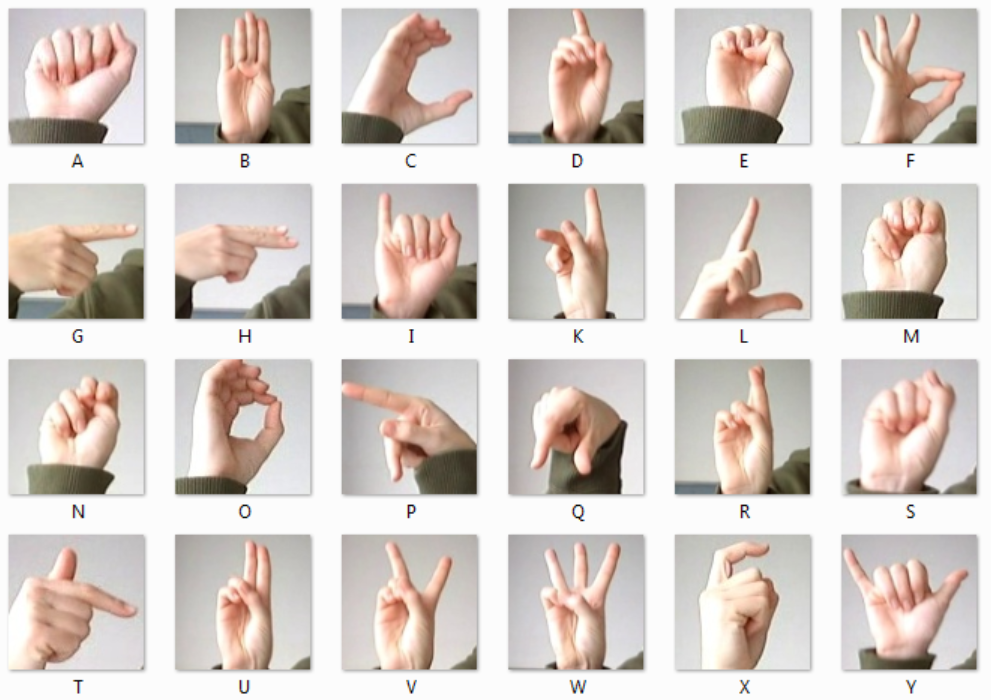

# Assignment structure

1. Part 1: Import, preprocess, and visualize the data.
2. Part 2: Design your own Dense Neural Network (NN) architecture for classifying MNIST in Keras.
3. Part 3: Train one of the Machine Learning classifiers that you learned about in DAT200.
4. Part 4: Compare and discuss the results.

## Supporting code

You may find the code below useful for plotting the metrics and calculating the F1-score for your model in Part 2.



In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import tensorflow as tf

"""
A function that plots the training and validation metrics over epochs
"""
def plot_training_history(training_history_object, list_of_metrics=None):

    """
    training_history_object: Object returned by model.fit() function in keras
    list_of_metrics: A list of MAX two metrics to be plotted
    """
    history_dict = training_history_object.history
    if list_of_metrics is None:
        list_of_metrics = [key for key in list(history_dict.keys()) if 'val_' not in key]

    trainHistDF = pd.DataFrame(history_dict)
    train_keys = list_of_metrics
    valid_keys = ['val_' + key for key in train_keys]
    nr_plots = len(train_keys)
    fig, ax = plt.subplots(1,nr_plots,figsize=(5*nr_plots,4))
    print(type(ax))
    for i in range(len(train_keys)):
        ax[i].plot(np.array(trainHistDF[train_keys[i]]), label='Training')
        ax[i].plot(np.array(trainHistDF[valid_keys[i]]), label='Validation')
        ax[i].set_xlabel('Epoch')
        ax[i].set_title(train_keys[i])
        ax[i].grid('on')
        ax[i].legend()
    fig.tight_layout
    plt.show()

"""
Custom Keras callback for computing the F1-score after each epoch.
This callback calculates both training and validation F1-scores
"""
class F1ScoreCallback(tf.keras.callbacks.Callback):
    def __init__(self, X_train, y_train, X_val, y_val):
        super().__init__()
        self.X_train, self.y_train = X_train, y_train
        self.X_val, self.y_val = X_val, y_val

    def on_epoch_end(self, epoch, logs=None):
        # Training F1
        y_train_pred = self.model.predict(self.X_train, verbose=0).argmax(axis=1)
        f1_train = f1_score(self.y_train, y_train_pred, average="macro")

        # Validation F1
        y_val_pred = self.model.predict(self.X_val, verbose=0).argmax(axis=1)
        f1_val = f1_score(self.y_val, y_val_pred, average="macro")

        logs["f1"] = f1_train
        logs["val_f1"] = f1_val
        print(f" — f1: {f1_train:.4f} — val_f1: {f1_val:.4f}")


## Library imports

In [21]:
import requests
path_train = "https://raw.githubusercontent.com/OysteinFalkeid/DAT300-H25/refs/heads/oystein/CA1_DAT300/sign_mnist_train.csv"
path_test = "https://raw.githubusercontent.com/OysteinFalkeid/DAT300-H25/refs/heads/oystein/CA1_DAT300/sign_mnist_test.csv"

# Task 1: Importing, preprocess and visualizing the data

In this assignment you yourselves will be responsible for the data-preprocessing. Use the cells below for preprocessing and visualization, and optionally some exploration of the dataset if you feel inclined.

## Importing data
You will need to upload both CSV files from the zip folder to Google Colab and run the code sell below to load the data.

In [22]:
# Sign language MNIST
train = pd.read_csv(path_train)
test  = pd.read_csv(path_test)

X_train = train.drop(columns=['label']).to_numpy(dtype=np.float32)
y_train = train['label'].to_numpy(dtype=np.int32)
X_test  = test.drop(columns=['label']).to_numpy(dtype=np.float32)
y_test  = test['label'].to_numpy(dtype=np.int32)


## Task 1.1 Preprocessing
Preprocess the data in whatever way you find sensible. Remember to comment on what you do.

In [36]:
letters_dict = {
    "A": 0,
    "B": 1,
    "C": 2,
    "D": 3,
    "E": 4,
    "F": 5,
    "G": 6,
    "H": 7,
    "I": 8,
    "K": 9,
    "L": 10,
    "M": 11,
    "N": 12,
    "O": 13,
    "P": 14,
    "Q": 15,
    "R": 16,
    "S": 17,
    "T": 18,
    "U": 19,
    "V": 20,
    "W": 21,
    "X": 22,
    "Y": 23
}

reverse_letters_dict = {i: j for j, i in letters_dict.items()}

# Adjust labels to account for missing 'J' and 'Z'
y_train_adjusted = np.where(y_train >= 9, y_train - 1, y_train)
y_test_adjusted = np.where(y_test >= 9, y_test - 1, y_test)



normalizer = tf.keras.layers.Rescaling(1./255)
X_train = np.array(normalizer(X_train))
X_test = np.array(normalizer(X_test))

## Task 1.2 Visualization
Visualize the data in whatever manner you find helpful/sensible and briefly comment on the plots.

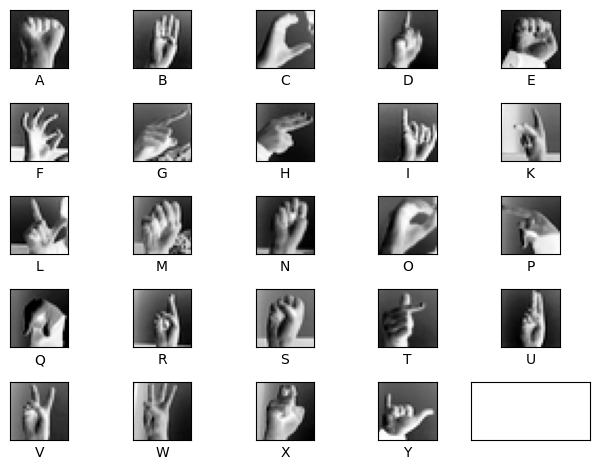

In [47]:
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.figure import Figure

axes: np.ndarray[Axes]
fig: Figure
fig, axes = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True,)
axes = axes.flatten()
for i in letters_dict.values():
    img = X_train[y_train_adjusted == i][0].reshape(28, 28)
    ax: Axes = axes[i]
    ax.imshow(img, cmap='Greys')
    ax.set_xlabel(reverse_letters_dict[i])
    # ax[i].imshow(img)

axes[0].set_xticks([]); axes[0].set_yticks([])
fig.tight_layout()
plt.show()

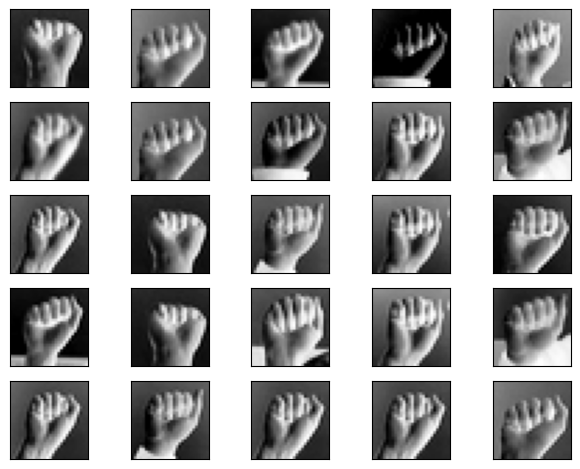

In [25]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(25):
    img = X_train[y_train_adjusted == letters_dict["A"]][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([]); ax[0].set_yticks([])
plt.tight_layout()
plt.show()

# Task 2: Design your own ANN architecture
In this task you are free to design the network architecture for the MNIST Gesture recognition challenge with a couple of stipulations:
* use **only Dense or fully connected layers**,
* use both **accuracy and the F1-score** as performance metrics.

Otherwise, you are free to use whatever loss-function, optimizer and activation functions you want and train it for as many epochs you want.

## Task 2.1: Implement your own network architecture
Design your network below:

(Feel free to add as many code and markdown cells as you want)

In [26]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    tf.keras.Input(shape=(784,)),  # Define the input shape using Input layer
    tf.keras.layers.Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dense(len(np.unique(y_train_adjusted)), activation="softmax")
])

opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 24)             │         1,560 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,296 (430.84 KB)

 Trainable params: 110,296 (430.84 KB)

 Non-trainable params: 0 (0.00 B)

## Task 2.2: Train your network and visualize the training history
Train the model and plot the training history in the code cell(s) below. Feel free to use the function `plot_training_history()` and the custom Keras callback `F1ScoreCallback()` from Supporting code section.

Epoch 1/12
329/344 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1852 - loss: 3.0582 — f1: 0.4180 — val_f1: 0.3662
344/344 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.1907 - loss: 3.0362 - val_accuracy: 0.4524 - val_loss: 2.0044 - f1: 0.4180 - val_f1: 0.3662
Epoch 2/12
333/344 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5268 - loss: 1.7722 — f1: 0.5420 — val_f1: 0.4493
344/344 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5282 - loss: 1.7673 - val_accuracy: 0.5611 - val_loss: 1.6079 - f1: 0.5420 - val_f1: 0.4493
Epoch 3/12
323/344 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6459 - loss: 1.3712 — f1: 0.6451 — val_f1: 0.5134
344/344 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.6471 - loss: 1.3671 - val_accuracy: 0.6627 - val_loss: 1.3127 - f1: 0.6451 - val_f1: 0.5134
Epoch 4/12
323/344 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7354 - loss: 1.1153 — f1: 0.7320 — val_f1: 0.5591
344/344 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7368 - loss: 1.1108 - val_accuracy: 0.74

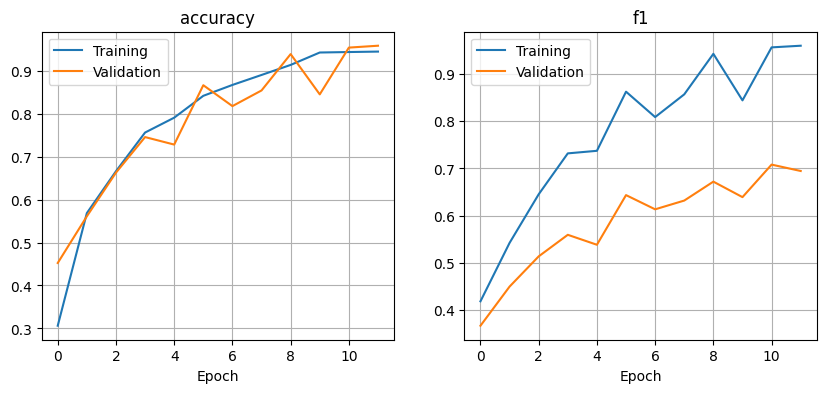

In [27]:
# Instantiate the F1ScoreCallback
f1_callback = F1ScoreCallback(X_train, y_train_adjusted, X_test, y_test_adjusted)

history = model.fit(X_train, y_train_adjusted, epochs=12, batch_size=64, validation_split=0.2, callbacks=[f1_callback])

plot_training_history(history, list_of_metrics=["accuracy", "f1"])

## Task 2.3: Discuss the results
**Question 2.3.1**: What could happen if the model is too shallow or too deep?

**Question 2.3.2**: How does the choice of train/validation/test split ratio affect the training process and the final performance of a deep learning model?

**Question 2.3.3**: How do accuracy and F1-Score values compare (are they similar or very different from each other)? What does it tell you about the MNIST dataset and which one of these metrics is more reliable in this case?

**Question 2.3.4**: Explain **very briefly** how each of the following model hyperparameters can impact the model's performance:
- Number of layers
- Number of neurons in a layer
- Batch size
- Optimizers
- Regularization techniques (such as L2 regularization).

# Task 3: Design and train a classical machine learning classifier
Pick your **favourite** machine learning classifer that you learned about in DAT200 and train it for the MNIST gesture recognition problem. (Hint: use the scikit-learn library). Remember to use **accuracy and the F1-score** as performance metrics.

In [28]:
import sklearn
y_train = y_train.astype(int)

model = sklearn.linear_model.LogisticRegression(max_iter=100, solver='saga', n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

f1 = f1_score(y_test.astype(int), y_pred, average='macro')
print("F1 Score (macro):", f1)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


max_iter reached after 129 seconds
F1 Score (macro): 0.6804963510810275


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


# Task 4: Compare and discuss
Evaluate the ANN model you implemented in Task 2 against the classical machine learning model from Task 3, using the test dataset. Compare the two models based on:

* Accuracies and F1-scores they attain
* Time it takes to train them

Did you experience any trouble when training models in tasks 2 and 3?

**Task 4 discussion Here:**

